**1) Hypothesis Generation:**




*   Product related:

1.   Lower weighted products may lead to more sales.(null hypothesis)
2.   More popular products lead to higher sales.(info unavailable)
3.   Products used on a daily basis like dairy products may lead to more sales.(null hypothesis)
4.   Expensive products will lead to higher sales; cigarettes form most of convenience stores' sales.(proven True)
5.   Item visibility will increase sales. (proven wrong, opposite)


*   Store related:
1.   Stores in more populated areas will achieve higher sales (Almost True)
2.   Newly established stores may lead to higher sales. (Null Hypothesis)
3.   Bigger sized outlets may lead to higher sales.(Null hypothesis, Alternate: Medium sized tend to accomplish highest sales)


**2) Loading packages and data**


In [559]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn import metrics
from sklearn.metrics import mean_absolute_error, accuracy_score, mean_absolute_percentage_error
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

In [521]:
sales= pd.read_csv("/content/Bigmart_Sales_Data/Train.csv")
sales_test = pd.read_csv("/content/Bigmart_Sales_Data/Test.csv")
sales = sales.rename(columns= {'Item_Outlet_Sales' : 'Sales'})
sales_test = sales_test.rename(columns= {'Item_Outlet_Sales' : 'Sales'})

**3) Data Structure and Content**

In [522]:
sales.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [523]:
sales.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


In [524]:
#checking how many null values in each column
sales.isnull().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Sales                           0
dtype: int64

In [525]:
missing_weight = sales.Item_Weight.isnull().sum()
total_weight = sales.Item_Weight.count()
print("missing Item_Weight percentage = {:.2f} %".format(missing_weight * 100 / total_weight))

missing_size = sales.Outlet_Size.isnull().sum()
total_size = total_weight
print("missing Outlet_Size percentage = {:.2f} %".format(missing_size * 100 / total_size))

missing Item_Weight percentage = 20.72 %
missing Outlet_Size percentage = 34.14 %


we see that we have a lot of missing data in the Item_Weight and Outlet_Size columns, we'll address them later when we get to the missing values section.

In [526]:
cat_cols = sales.select_dtypes(include=['object'])

cat_cols.nunique()

Item_Identifier         1559
Item_Fat_Content           5
Item_Type                 16
Outlet_Identifier         10
Outlet_Size                3
Outlet_Location_Type       3
Outlet_Type                4
dtype: int64

We see here that Item_Identifier has too many unique variables! It would be best to drop that column, specially that it most likely does not have much of an effect on our target.

In [527]:
#drop Item_Identifier column
sales = sales.drop('Item_Identifier', axis=1)
sales_test = sales_test.drop('Item_Identifier', axis=1)

Another point, why does Item_Fat_content have too many unique values? I remember it only containing Low Fat and Regular, let's check its unique values.

In [528]:
sales.Item_Fat_Content.unique()

array(['Low Fat', 'Regular', 'low fat', 'LF', 'reg'], dtype=object)

That's why! Now, we should rename the duplicate values.



In [529]:
sales.Item_Fat_Content.replace({'LF':'Low Fat', 'low fat':'Low Fat', 'reg':'Regular'}, inplace=True)
sales_test.Item_Fat_Content.replace({'LF':'Low Fat', 'low fat':'Low Fat', 'reg':'Regular'}, inplace=True)
sales.Item_Fat_Content.unique()

array(['Low Fat', 'Regular'], dtype=object)

**4) Exploratory Data Analysis**

<Axes: xlabel='Sales', ylabel='Outlet_Identifier'>

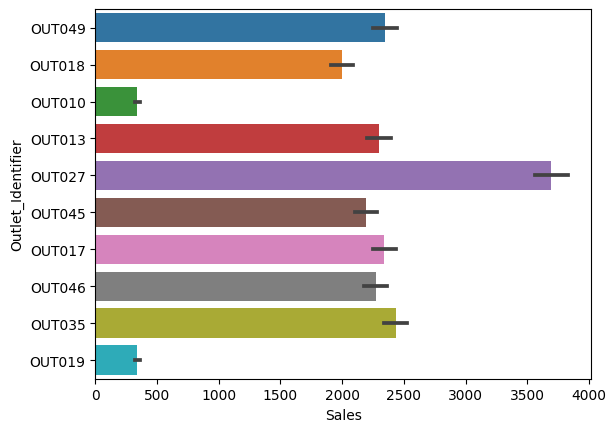

In [530]:
sns.barplot(x=sales.Sales, y=sales.Outlet_Identifier)

This shows that some outlets achieve significally higher sales than others!

<Axes: xlabel='Item_Weight', ylabel='Sales'>

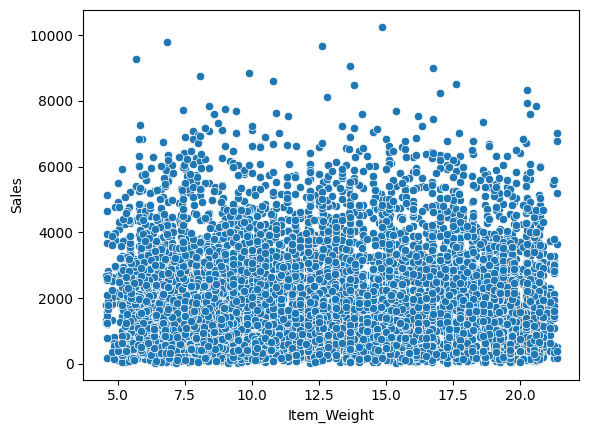

In [531]:
sns.scatterplot(x=sales.Item_Weight, y=sales.Sales)

Looks like our hypothesis that Lower item weight may lead to higher sales was proved wrong by the above scatter plot.

<Axes: xlabel='Item_MRP', ylabel='Sales'>

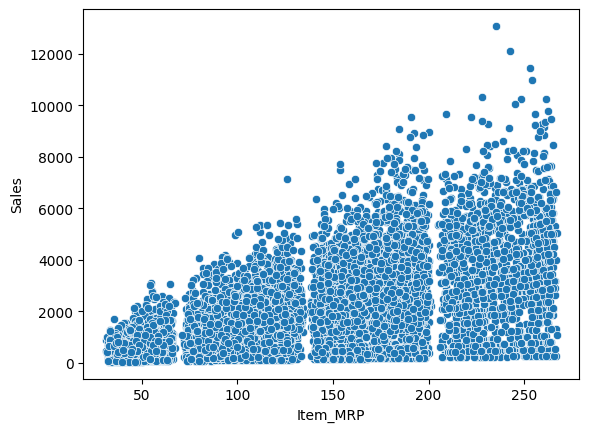

In [532]:
sns.scatterplot(x=sales.Item_MRP, y=sales.Sales)

Makes sense! Higher item price does lead to higher sales.

<Axes: xlabel='Sales', ylabel='Item_Type'>

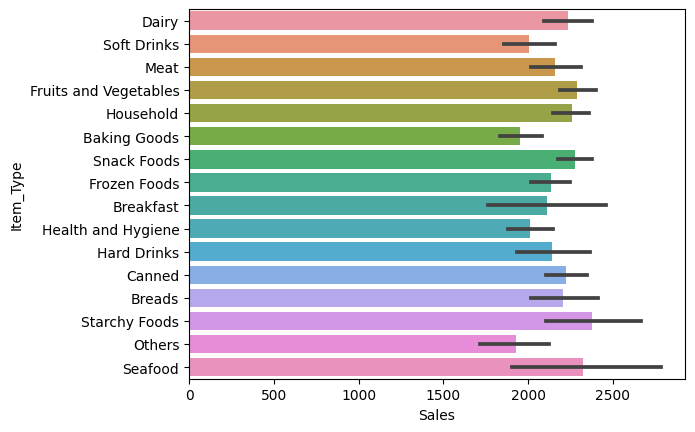

In [533]:
sns.barplot(x=sales.Sales, y=sales.Item_Type)

Another failed hypothesis, item type doesn't seem to have that much of effect on sales.

<Axes: xlabel='Item_Visibility', ylabel='Sales'>

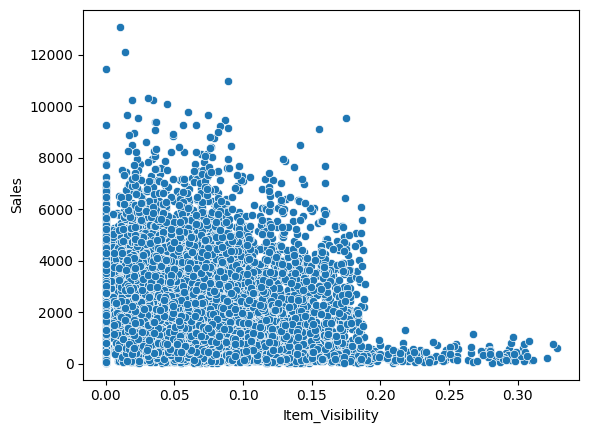

In [534]:
sns.scatterplot(x=sales.Item_Visibility, y=sales.Sales)

Looks like we have a lot of items with visibility = 0, which would probably mean the value for this item is missing.

<Axes: xlabel='Sales', ylabel='Outlet_Location_Type'>

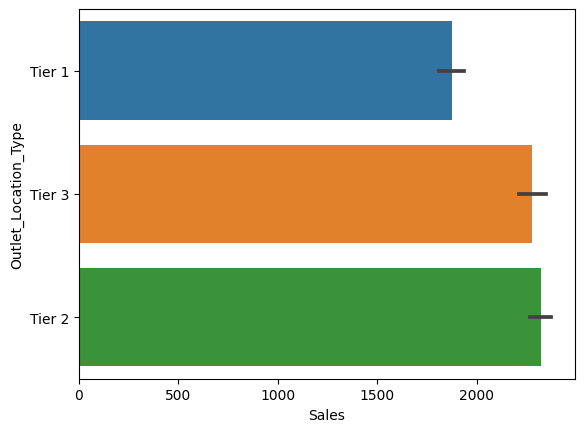

In [535]:
sns.barplot(x=sales.Sales, y=sales.Outlet_Location_Type)

Tier 2 and Tier 3 cities seemed to achieve slightly higher sales than tier 1

<Axes: xlabel='Outlet_Establishment_Year', ylabel='Sales'>

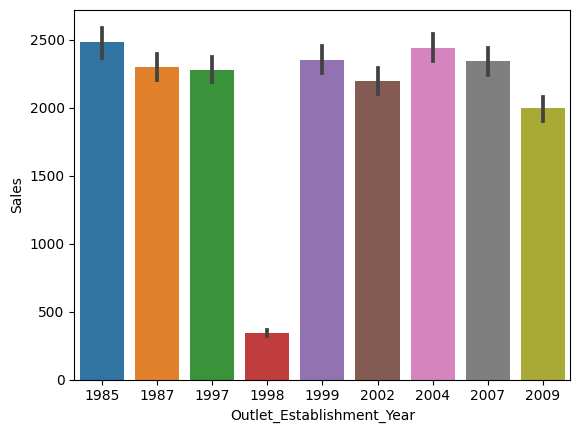

In [536]:
sns.barplot(x=sales.Outlet_Establishment_Year, y=sales.Sales)

<Axes: xlabel='Outlet_Size', ylabel='Sales'>

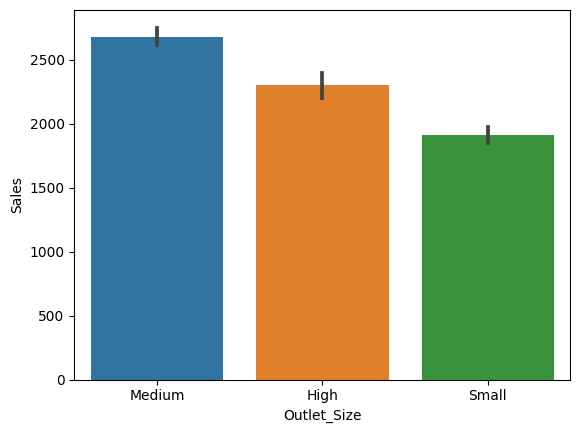

In [537]:
sns.barplot(x=sales.Outlet_Size, y=sales.Sales)

**6) Missing Values**

In [538]:
#replace null values in Item_Weights column by the average weight for each Item_Type

average_weights = sales.groupby('Item_Type')['Item_Weight'].transform('mean')
sales.Item_Weight.fillna(average_weights, inplace = True)
sales_test.Item_Weight.fillna(average_weights, inplace = True)


sales.isnull().sum()


Item_Weight                     0
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Sales                           0
dtype: int64

In [539]:
#for Outlet_Size we will use a regression model to fill in the missing values.
sales.Outlet_Size.fillna(method='bfill', axis=0, inplace=True)
sales_test.Outlet_Size.fillna(method='bfill', axis=0, inplace=True)
sales.isnull().sum()

Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Sales                        0
dtype: int64

Remember how Item_Visibility had a lot of missing values represented as zeros?

In [540]:
sales.Item_Visibility.value_counts()[0]

526

<Axes: xlabel='Item_Visibility', ylabel='Sales'>

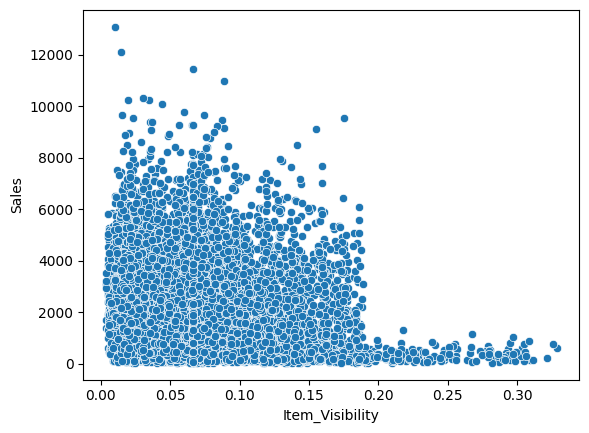

In [541]:
mean = sales.Item_Visibility.mean()
sales.Item_Visibility.replace({0.000000 : mean}, inplace=True)
sales_test.Item_Visibility.replace({0.000000 : mean}, inplace=True)
sns.scatterplot(x=sales.Item_Visibility, y=sales.Sales)

Now, we got rid of all the missing values.

**5) Investigating for and treating Outliers**

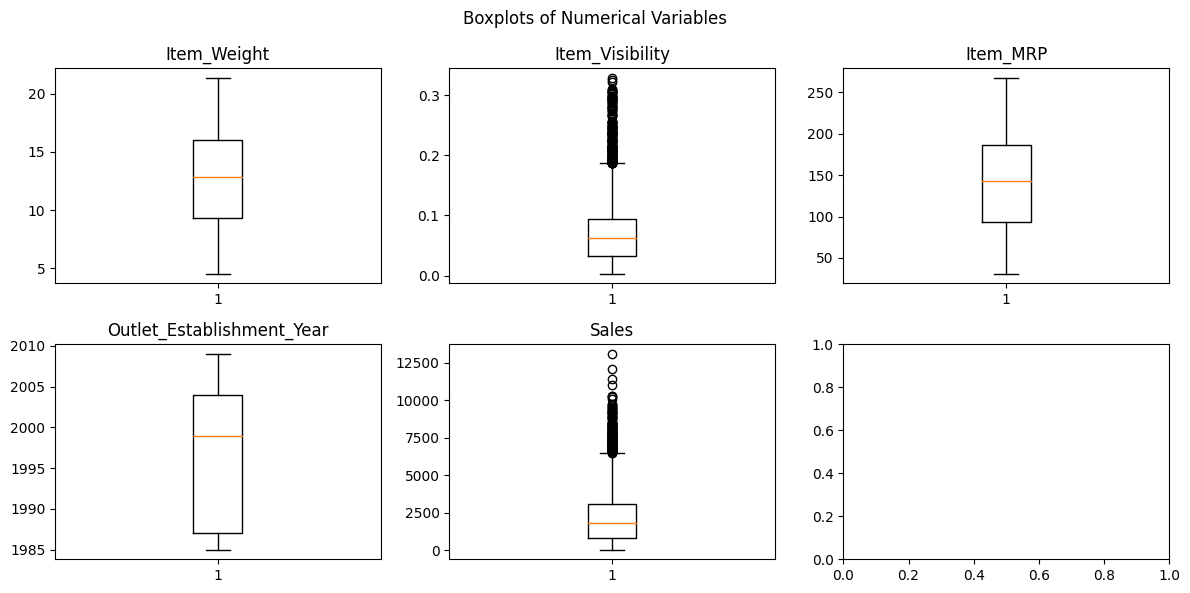

In [542]:
cat_cols = sales.select_dtypes(include=['object']).columns
num_cols = sales.select_dtypes(include=['float64', 'int64']).columns

num_cols_count = len(num_cols)
num_cols_per_row = 3  # Number of boxplots to display per row
num_rows = math.ceil(num_cols_count / num_cols_per_row)

fig, axs = plt.subplots(num_rows, num_cols_per_row, figsize=(12, 3*num_rows))
fig.suptitle("Boxplots of Numerical Variables")

for i, col in enumerate(num_cols):
    row = i // num_cols_per_row
    col_index = i % num_cols_per_row
    ax = axs[row, col_index] if num_rows > 1 else axs[col_index]
    ax.boxplot(sales[col])
    ax.set_title(col)

plt.tight_layout()
plt.show()

It appears that Item_Visibility and Sales columns has outliers. The rest of our numerical data seems just fine! Now, let's see how we will deal with these outliers.

In [543]:
sales.Item_Visibility.describe()

count    8523.000000
mean        0.070213
std         0.048742
min         0.003575
25%         0.033085
50%         0.062517
75%         0.094585
max         0.328391
Name: Item_Visibility, dtype: float64

{'whiskers': [<matplotlib.lines.Line2D at 0x7f5b70fe3ac0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f5b70fe1570>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f5b73fad630>],
 'medians': [<matplotlib.lines.Line2D at 0x7f5b70fe2320>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f5b70fe3580>],
 'means': []}

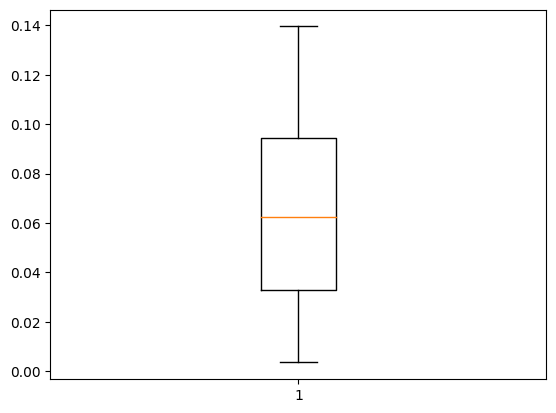

In [544]:
# Apply Winsorization to Item_Visibility
winsorized_column = np.percentile(sales.Item_Visibility, [0, 90])
sales.Item_Visibility = np.clip(sales.Item_Visibility, winsorized_column[0], winsorized_column[1])
plt.boxplot(sales.Item_Visibility)

{'whiskers': [<matplotlib.lines.Line2D at 0x7f5b8120a560>,
 'caps': [<matplotlib.lines.Line2D at 0x7f5b710955d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f5b81321150>],
 'medians': [<matplotlib.lines.Line2D at 0x7f5b71095420>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f5b71094580>],
 'means': []}

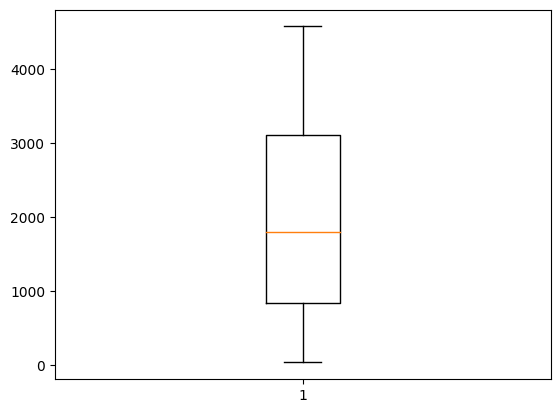

In [545]:
# Apply Winsorization to Sales
winsorized_column = np.percentile(sales.Sales, [0, 90])
sales.Sales = np.clip(sales.Sales, winsorized_column[0], winsorized_column[1])
plt.boxplot(sales.Sales)

In [546]:
sales.Sales.describe()

count    8523.000000
mean     2053.356885
std      1407.575238
min        33.290000
25%       834.247400
50%      1794.331000
75%      3101.296400
max      4570.051200
Name: Sales, dtype: float64

Great! Now it looks like we got rid of the outliers in our data.

**6) Scaling**


In [547]:
scaler = MinMaxScaler()
num_cols = num_cols.drop('Sales')
sales[num_cols] = scaler.fit_transform(sales[num_cols], sales.Sales)

cat_cols_test = sales_test.select_dtypes(include=['object']).columns
num_cols_test = sales_test.select_dtypes(include=['float64', 'int64']).columns

sales_test[num_cols_test] = scaler.fit_transform(sales_test[num_cols_test], sales.Sales)

In [548]:
sales[num_cols]

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year
0,0.282525,0.091751,0.927507,0.583333
1,0.081274,0.115518,0.072068,1.000000
2,0.770765,0.096994,0.468288,0.583333
3,0.871986,0.460184,0.640093,0.541667
4,0.260494,0.460184,0.095805,0.083333
...,...,...,...,...
8518,0.137541,0.391414,0.777729,0.083333
8519,0.227746,0.319316,0.326263,0.708333
8520,0.359929,0.232541,0.228492,0.791667
8521,0.158083,1.000000,0.304939,1.000000


**7) Encoding**

Let's take another look at our categorical columns.

In [549]:
#update cat_cols and num_cols
cat_cols = sales.select_dtypes(include=['object'])
num_cols = sales.select_dtypes(include=['float64', 'int64'])

cat_cols_test = sales_test.select_dtypes(include=['object'])
num_cols_test = sales_test.select_dtypes(include=['float64', 'int64'])

cat_cols.nunique()

Item_Fat_Content         2
Item_Type               16
Outlet_Identifier       10
Outlet_Size              3
Outlet_Location_Type     3
Outlet_Type              4
dtype: int64

Based on the meanings of our data, we'll use Ordinal Encoding on Item_Fat_Content, Outlet_Size & Outlet_Location_Type.

We'll use One Hot Encoding for the rest of our categorical data.

In [550]:
Ordinal_cols = sales[['Item_Fat_Content', 'Outlet_Size', 'Outlet_Location_Type']].columns
Ordinal_cols_test = sales_test[['Item_Fat_Content', 'Outlet_Size', 'Outlet_Location_Type']].columns

OH = cat_cols.columns.difference(Ordinal_cols)
OH_test = cat_cols_test.columns.difference(Ordinal_cols_test)

ordinal_encoder = OrdinalEncoder()
sales[Ordinal_cols] = ordinal_encoder.fit_transform(sales[Ordinal_cols])
sales_test[Ordinal_cols_test] = ordinal_encoder.fit_transform(sales_test[Ordinal_cols_test])


OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

OH_cols = pd.DataFrame(OH_encoder.fit_transform(sales[OH]))
OH_cols_test = pd.DataFrame(OH_encoder.fit_transform(sales_test[OH_test]))

OH_cols.index = sales.index
OH_cols_test.index = sales_test.index

sales = sales.drop(OH, axis=1)
sales_test = sales_test.drop(OH_test, axis=1)

sales = pd.concat([sales, OH_cols], axis=1)
sales_test = pd.concat([sales_test, OH_cols_test], axis=1)

sales.columns = sales.columns.astype(str)
sales_test.columns = sales_test.columns.astype(str)

In [551]:
sales.head()


,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Sales,0,1,...,20,21,22,23,24,25,26,27,28,29
0,0.282525,0.0,0.091751,0.927507,0.583333,1.0,0.0,3735.1380,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,0.081274,1.0,0.115518,0.072068,1.000000,1.0,2.0,443.4228,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.770765,0.0,0.096994,0.468288,0.583333,1.0,0.0,2097.2700,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,0.871986,1.0,0.460184,0.640093,0.541667,0.0,2.0,732.3800,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.260494,0.0,0.460184,0.095805,0.083333,0.0,2.0,994.7052,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


**8) Model**

In [552]:
#split the data
X = sales.drop('Sales', axis=1)
y = sales.Sales
train_X, val_X, train_y, val_y = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=1)

In [553]:
model_1 = LinearRegression()
model_1.fit(train_X, train_y)
predictions = model_1.predict(val_X)
MAE = mean_absolute_error(val_y, predictions)

print(f"MAE: {MAE:.2f}")

MAE: 715.24


In [554]:
model_2 = RandomForestRegressor(n_estimators=300, n_jobs=-1, random_state =0,)
model_2.fit(train_X, train_y)
predictions = model_2.predict(val_X)
MAE = mean_absolute_error(val_y, predictions)

print(f"MAE: {MAE:.2f}")

MAE: 662.91


In [555]:
model_3 = XGBRegressor(n_estimators = 500, learning_rate=0.03, n_jobs = -1, early_stopping_rounds=5, random_state=1)
model_3.fit(train_X, train_y, eval_set = [(val_X, val_y)], verbose = False)
predictions = model_3.predict(val_X)
MAE = mean_absolute_error(val_y, predictions)

print(f"MAE: {MAE:.2f}")

MAE: 647.88


So the best model is the XGBoost model, let's use it to predict the target in our test data and upload it to a new csv file.

In [556]:
sales_predictions = model_3.predict(sales_test)
sales_predictions = pd.DataFrame(sales_predictions, columns=['Sales_Predictions'])

In [557]:
sales_predictions.to_csv("/content/Bigmart_Sales_Data/Sales_predictions.csv")

**9) Summary**

To summarize what we did,

*   We first generated some hypotheses based on the problem statement.

*   After that, we took a look at our data, investigated it and got to understand its contents.


*   Throughout our exploration of the data, we came to prove some hypotheses wrong and some right. Even discovered a few interesting things!

*   We started dealing with the missing values of the data in the best way we found appropriate for each column.

*   Then, we discovered our data had outliers in some columns and used winsorization to treat them.

*   We then used MinMaxScaling to scale the numerical columns.

*   That's when we went ahead and encoded the categorical columns, some using ordinal encoding, some using OH encoding, depending on the nature of the data in each column.


Finally, we got to try out a few models to see which model behaved the best!

XGBoost turned out to achieve the best results and hence, we used it to predict the sales for our test data.

And that's all about our journey with Bigmart's sales data!